In [16]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
!pip install keras-metrics
!pip install scikit-plot
!pip install scipy
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
total_data = pd.read_csv("/content/drive/My Drive/cs230 project self/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [20]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)):
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i)
      wout_el = re.sub(pattern2,'\n',wout_sc)
      wout_mspaces = re.sub(pattern3,' ',wout_el)
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [23]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
100%|██████████| 94379/94379 [05:38<00:00, 278.46it/s]


In [24]:
pickle_file_path = "/content/drive/My Drive/cs230 project self/facts_opinions.pkl"
total_data.to_pickle(pickle_file_path)

In [25]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode ll hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


In [26]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [28]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.95,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.95,random_state=42)

Shape of X_Train:: (85177, 1)
Shape of X_Cv:: (4483, 1)
Shape of X_Test:: (4719, 1)
Shape of Y_Train:: (85177, 1)
Shape of Y_Cv:: (4483, 1)
Shape of Y_Test:: (4719, 1)


In [29]:
x_test.to_csv("/content/drive/My Drive/cs230 project self/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/cs230 project self/y_test.csv",index=False)

In [33]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1393


In [34]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 85177/85177 [00:04<00:00, 20716.39it/s]


In [35]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data

In [36]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 85177/85177 [32:00<00:00, 44.35it/s]



Generating Vectors......


100%|██████████| 4483/4483 [01:59<00:00, 37.64it/s]



Generating Vectors......


100%|██████████| 4719/4719 [01:50<00:00, 42.60it/s]


In [37]:
lstm_model = Sequential()
lstm_model.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model.add(LSTM(20))
lstm_model.add(Dense(2, activation='softmax'))
checkpoint = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values=lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint])

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.8884 - loss: 0.2735
Epoch 1: val_loss improved from inf to 0.05116, saving model to /content/drive/My Drive/cs230 project self/saved models/model-001-0.952065-0.984385.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - acc: 0.8891 - loss: 0.2720 - val_acc: 0.9844 - val_loss: 0.0512
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9905 - loss: 0.0339
Epoch 2: val_loss improved from 0.05116 to 0.04464, saving model to /content/drive/My Drive/cs230 project self/saved models/model-002-0.990549-0.987508.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - acc: 0.9905 - loss: 0.0339 - val_acc: 0.9875 - val_loss: 0.0446
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.9972 - loss: 0.0130
Epoch 3: val_loss did not improve from 0.04464
86/86 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - acc: 0.9972 - loss: 0.0130 - val_acc: 0.9877 - val_loss: 0.0459


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_prob = lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step
Validation Accuracy: 0.9877
Validation Precision: 0.9872
Validation Recall: 0.9857
Validation F1 Score: 0.9865


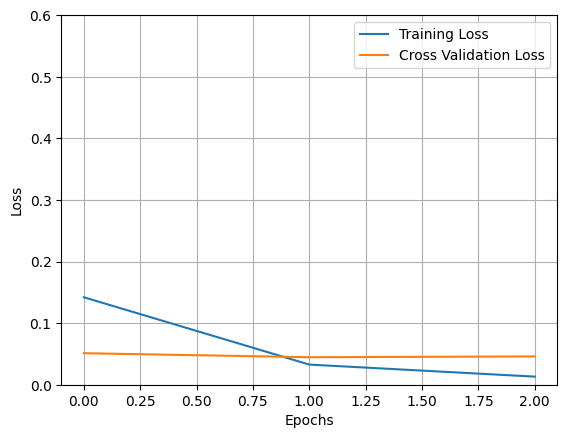

In [40]:
plt.plot(values.history['loss'],label = "Training Loss")
plt.plot(values.history['val_loss'],label = "Cross Validation Loss")
plt.ylim([0,0.60])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

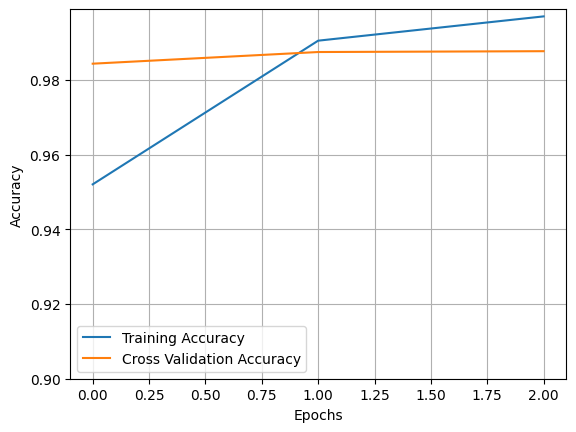

In [41]:
plt.plot(values.history['acc'],label = "Training Accuracy")
plt.plot(values.history['val_acc'],label = "Cross Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.900,0.999])
plt.grid()
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import confusion_matrix
from IPython.display import display
classes=["Opinions","Facts "]
y_pred_probs = lstm_model.predict(x_test_vec)
y_pred = np.argmax(y_pred_probs,axis=1)
#y_pred = lstm_model.predict_classes(x_test_vec)
conf_df = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=classes,index=classes)
conf_df.index.name = 'True labels'
display(conf_df)

148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


,Opinions,Facts
True labels,,
Opinions,2442,33
Facts,37,2207


In [43]:
numer = conf_df.iloc[0,0]+conf_df.iloc[1,1]
denom = conf_df.iloc[0,0]+conf_df.iloc[0,1]+conf_df.iloc[1,0]+conf_df.iloc[1,1]
print("Accuracy on Test Data::",100*numer/denom)

Accuracy on Test Data:: 98.51663488027124
